# UM-Bridge with QMCPy

Using QMCPy to evaluate the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) and approximate the expectation with respect to a uniform random variable. 

## Imports

In [1]:
import umbridge
import qmcpy as qp

## Start Docker Container

See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [2]:
!docker run --name muqbp -d -it -p 4243:4243 linusseelinger/benchmark-muq-beam-propagation:latest

8192780429eeace8439d0007df81db12a43215530634f5b5737bfc705135ccc5


## Problem Setup

Initialize a QMCPy sampler and distribution.

In [3]:
sampler = qp.DigitalNetB2(dimension=3,seed=7) # DISCRETE DISTRIBUTION
distribution = qp.Uniform(sampler,lower_bound=1,upper_bound=1.05) # TRUE MEASURE

Initialize a UM-Bridge model and wrap it into a QMCPy compatible Integrand

In [4]:
model = umbridge.HTTPModel('http://localhost:4243','forward')
umbridge_config = {"d": sampler.d}
integrand = qp.UMBridgeWrapper(distribution,model,umbridge_config,parallel=False) # INTEGRAND

## Model Evaluation

In [5]:
x = sampler(16) # same as sampler.gen_samples(16)
y = integrand.f(x)
print(y.shape)
print(type(y))
print(y.dtype)

(31, 16)
<class 'numpy.ndarray'>
float64


## Automatically Approximate the Expectation

In [6]:
qmc_stop_crit = qp.CubQMCNetG(integrand,abs_tol=2.5e-2) # QMC STOPPING CRITERION
solution,data = qmc_stop_crit.integrate()
print(data)

Data (Data)
    solution        [  0.      3.855  14.69  ... 898.921 935.383 971.884]
    comb_bound_low  [  0.      3.854  14.688 ... 898.901 935.362 971.862]
    comb_bound_high [  0.      3.855  14.691 ... 898.941 935.404 971.906]
    comb_bound_diff [0.    0.001 0.003 ... 0.041 0.042 0.044]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(11)
    n               [1024 1024 1024 ... 2048 2048 2048]
    time_integrate  9.566
CubQMCNetG (AbstractStoppingCriterion)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_limit         2^(35)
UMBridgeWrapper (AbstractIntegrand)
Uniform (AbstractTrueMeasure)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (AbstractLDDiscreteDistribution)
    d               3
    replications    1
    randomize       LMS_DS
    gen_mats_source joe_kuo.6.21201.txt
    order           NATURAL
    t               63
    alpha           1
    n_limit         2^(32)
    entropy         7

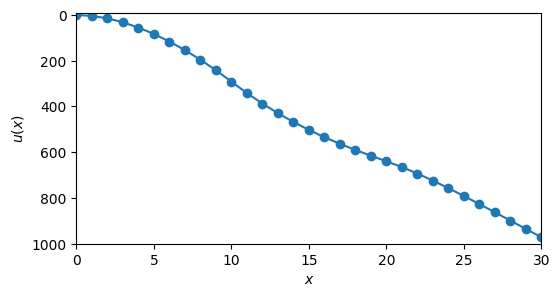

In [7]:
from matplotlib import pyplot
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(solution,'-o')
ax.set_xlim([0,len(solution)-1]); ax.set_xlabel(r'$x$')
ax.set_ylim([1000,-10]);  ax.set_ylabel(r'$u(x)$');

## Parallel Evaluation

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `parallel=os.cpu_count()`.

In [8]:
import os
print('Available CPUs: %d'%os.cpu_count())

Available CPUs: 12


In [10]:
integrand = qp.UMBridgeWrapper(distribution,model,umbridge_config,parallel=8)
solution,data = qp.CubQMCNetG(integrand,abs_tol=2.5e-2).integrate()
data

Data (Data)
    solution        [  0.      3.855  14.69  ... 898.921 935.383 971.884]
    comb_bound_low  [  0.      3.854  14.688 ... 898.901 935.362 971.862]
    comb_bound_high [  0.      3.855  14.691 ... 898.941 935.404 971.906]
    comb_bound_diff [0.    0.001 0.003 ... 0.041 0.042 0.044]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(11)
    n               [1024 1024 1024 ... 2048 2048 2048]
    time_integrate  4.719
CubQMCNetG (AbstractStoppingCriterion)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_limit         2^(35)
UMBridgeWrapper (AbstractIntegrand)
Uniform (AbstractTrueMeasure)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (AbstractLDDiscreteDistribution)
    d               3
    replications    1
    randomize       LMS_DS
    gen_mats_source joe_kuo.6.21201.txt
    order           NATURAL
    t               63
    alpha           1
    n_limit         2^(32)
    entropy         7

## Shut Down Docker Image

In [11]:
!docker rm -f muqbp

muqbp
